# Generalized Linear Models

Part of our proposed models include models that are based on generalize linear models such as Poisson regression and Negative Binomial. Also, we included Zero-Inflated and Hurdle models to cope with the high proportion of zero counts.

This latter characteristic was a determinant to search for discrete-valued models that could cope with a high proportion of zero counts. Unfortunately, Python did not have a documented and certified library able to run Hurdle models, and thus, we decided to use R.

In this notebook you fill find how to read and process the `CARTA` dataset in R. That means that we included an R version of all the developed functions for data processing and variable generation that were written in Python. 

The following libraries are required to run this notebook:

In [112]:
library(tidyverse)
library(lubridate)
library(tibble)
library(data.table)
library(MASS)
library(pscl)
library(caret)
library(readr)
library(janitor)

CARTA dataset:

In [3]:
carta = read_csv('data/jmartinez/Transit_Data/carta.csv')

Rows: 9705963 Columns: 26

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): route_id, direction_desc, service_period, service_kind
dbl  (15): trip_id, stop_id, stop_sequence, stop_lat, stop_lon, direction_id...
dttm  (5): scheduled_arrival_time, actual_arrival_time, scheduled_datetime, ...
date  (2): date, trip_date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [58]:
length(which(is.na(carta$route_id) == T, arr.ind = T))

[1] 1658648

The following cell transforms some variables into string or categorical variables:

In [59]:
carta$trip_id = as.character(carta$trip_id)
carta$stop_id = as.character(carta$stop_id)
carta$route_id = as.character(carta$route_id)
carta$direction_id = as.character(carta$direction_id)
carta$hour = factor(carta$hour)
carta$month = factor(carta$month)

In [60]:
head(carta)

trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,⋯,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dttm>,<dttm>,<dbl>,<date>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
132994,1900-01-01 04:55:00,1900-01-01 04:52:00,1351,1,35.05266,-85.30972,1,0,1,⋯,2019-01-02 04:52:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.350000,0,weekday
132994,1900-01-01 04:55:41,1900-01-01 04:56:00,12,2,35.05070,-85.30953,1,0,0,⋯,2019-01-02 04:56:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.343167,0,weekday
132994,1900-01-01 04:56:20,1900-01-01 04:57:00,1555,3,35.04883,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.336667,0,weekday
132994,1900-01-01 04:56:35,1900-01-01 04:57:00,1579,4,35.04812,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.334167,0,weekday
132994,1900-01-01 04:57:22,1900-01-01 04:57:00,1354,5,35.04598,-85.30952,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.326333,0,weekday
132994,1900-01-01 04:57:35,1900-01-01 04:57:00,1353,6,35.04538,-85.30945,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.324167,0,weekday


## Data partition according to lock-down and ridership decline

Chattanooga's steep decline started the week of **March 5th** before hitting a low also on the week of April 19 with a low of 8,077 weekly riders.

 - Pre-lockdown data: Before 2020-03-05.
     * `date < 2020-03-05`
 - Post-lockdown data: After 2020-03-05.
     * `date >= 2020-03-05`

In [104]:
Pre_lock = carta %>%
    filter(date < '2020-03-05')

Post_lock = carta %>%
    filter(date >= '2020-03-05')

In [105]:
head(Pre_lock)

trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,⋯,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dttm>,<dttm>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
132994,1900-01-01 04:55:00,1900-01-01 04:52:00,1351,1,35.05266,-85.30972,1,0,1,⋯,2019-01-02 04:52:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.350000,0,weekday
132994,1900-01-01 04:55:41,1900-01-01 04:56:00,12,2,35.05070,-85.30953,1,0,0,⋯,2019-01-02 04:56:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.343167,0,weekday
132994,1900-01-01 04:56:20,1900-01-01 04:57:00,1555,3,35.04883,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.336667,0,weekday
132994,1900-01-01 04:56:35,1900-01-01 04:57:00,1579,4,35.04812,-85.30955,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.334167,0,weekday
132994,1900-01-01 04:57:22,1900-01-01 04:57:00,1354,5,35.04598,-85.30952,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.326333,0,weekday
132994,1900-01-01 04:57:35,1900-01-01 04:57:00,1353,6,35.04538,-85.30945,1,0,0,⋯,2019-01-02 04:57:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.324167,0,weekday


## Data Partition Function:

The `get_data_partition()` function divides a dataset into train and test sets. This function takes three input values:

* `rt == route_id`
* `di == direction_id`
* `st == stop_id`

Then, it returns the train and test sets as `*.csv` files. These two files are saved in the folder of the given `stop_id`.

In [15]:
get_data_partition <- function(rt, di, st){
    path = paste0('data', '/', 'jmartinez', '/', 'Data_for_RF_Models', '/', 'Board_Counts', '/',
                  paste('route', rt, sep = '_'), '/', paste('direction', di, sep = ''), '/',
                  paste('bus_stop', st, sep = '_'), '/', 'data.csv')
    dtt = read_csv(path)[, -c(1)]
    
    set.seed(123)
    rand_ind = createDataPartition(dtt$board_count, times = 1, p = 0.8, list = FALSE)
    
    train_set = dtt[rand_ind,]
    test_set = dtt[-rand_ind, ]
    
    train_set_path = paste0('data', '/', 'jmartinez', '/', 'Data_for_RF_Models', '/', 'Board_Counts', '/',
                            paste('route', rt, sep = '_'), '/', paste('direction', di, sep = ''), '/',
                            paste('bus_stop', st, sep = '_'), '/', 'train_data.csv')
    
    test_set_path = paste0('data', '/', 'jmartinez', '/', 'Data_for_RF_Models', '/', 'Board_Counts', '/',
                           paste('route', rt, sep = '_'), '/', paste('direction', di, sep = ''), '/',
                           paste('bus_stop', st, sep = '_'), '/', 'test_data.csv')
    
    write.csv(train_set, train_set_path, row.names = F)
    write.csv(test_set, test_set_path, row.names = F)
    
    print('Done!')
}

In [16]:
get_data_partition('4', '1', '12')

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  mean_temp = col_double(),
  mean_precip = col_double(),
  month_average_board_count = col_double(),
  surrounding_board_count = col_double()
)




[1] "Done!"


# Radial Influence

This section is the translated version of the `radial_influence()` written in Python. It identifies the bus stops that are within a half-mile radius with respect to a given bus stop.

## Bus Stops dataset

In [4]:
Bus_stops = read_csv('data/jmartinez/Transit_Data/Bus_Stops.csv')
Bus_stops$stop_id <- as.character(Bus_stops$stop_id)

head(Bus_stops)


── Column specification ────────────────────────────────────────────────────────
cols(
  stop_id = col_double(),
  stop_lon = col_double(),
  stop_lat = col_double()
)




stop_id,stop_lon,stop_lat
<chr>,<dbl>,<dbl>
971,-85.24681,35.02435
146,-85.30462,34.98958
1545,-85.25086,35.02603
972,-85.24853,35.02572
81,-85.30489,34.99030
90,-85.30497,34.99125


In [5]:
radial_influence <- function(st, DT){
  
    n_row = dim(DT)[1]
    
    x0 = DT[DT['stop_id'] == st, ]$stop_lon
    y0 = DT[DT['stop_id'] == st, ]$stop_lat
    
    radial_dist = 0
    condition = 0
    
    for(i in c(1:n_row)){
        radial_dist[i] = sqrt((x0 - DT$stop_lon[i])^{2} + (y0 - DT$stop_lat[i])^{2})
    }
    radial_dist = radial_dist
    influence = data.frame(cbind('stop_id' = DT$stop_id, 'Radial_Distance' = radial_dist))
    influence$Radial_Distance = as.numeric(as.character(influence$Radial_Distance))
        
    Influence = influence %>%
      mutate(Condition = if_else((Radial_Distance <= 0.007246377) == T, 'Inside', 'Outside'))
   
    return(Influence)
    
}

### Example

In [6]:
XdistX = radial_influence('12', Bus_stops)
head(XdistX)

,stop_id,Radial_Distance,Condition
,<chr>,<dbl>,<chr>
1,971,0.06803262,Outside
2,146,0.06131507,Outside
3,1545,0.06364519,Outside
4,972,0.06592259,Outside
5,81,0.06057911,Outside
6,90,0.05963092,Outside


In [8]:
Bus_stops_Example <- Bus_stops
Bus_stops_Example$Condition = XdistX$Condition
head(Bus_stops_Example)

stop_id,stop_lon,stop_lat,Condition
<chr>,<dbl>,<dbl>,<chr>
971,-85.24681,35.02435,Outside
146,-85.30462,34.98958,Outside
1545,-85.25086,35.02603,Outside
972,-85.24853,35.02572,Outside
81,-85.30489,34.99030,Outside
90,-85.30497,34.99125,Outside


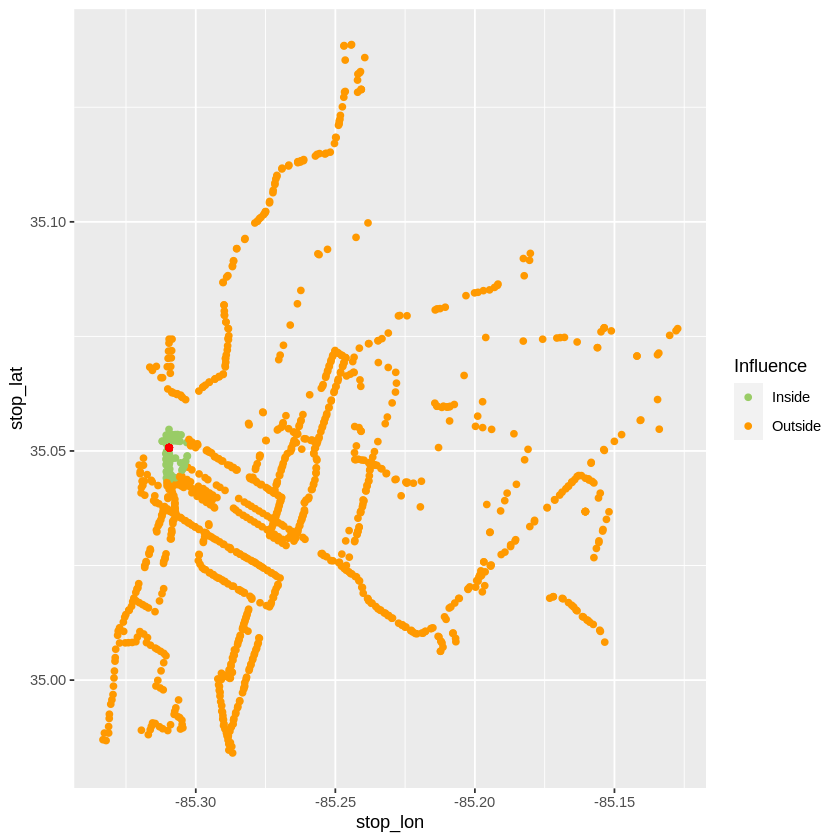

In [10]:
Bus_stops_Example %>%
    ggplot(aes(x = stop_lon, y = stop_lat, colour = Condition)) +
    geom_point() +
    geom_point(aes(x = Bus_stops_Example[Bus_stops_Example['stop_id'] ==  '12',]$stop_lon,
                   y = Bus_stops_Example[Bus_stops_Example['stop_id'] ==  '12',]$stop_lat), color = 'red') +
    scale_colour_manual(name = "Influence",
                        values = c("Inside" = "#99CC66",
                                   "Outside" = "#FF9900"))

## Subordinate or Auxiliary Functions

### Data Normalization

In [12]:
normalizer <- function(x){
    
    x_min = min(x)
    x_max = max(x)
    x_norm = (x - x_min)/(x_max - x_min)
    
    return(x_norm)
} 

### Data Standardization

In [13]:
standardizer <- function(x){
    x_std = x.std()
    x_mean = x.mean()
    x_standard = (x - x_mean)/x_std
    
    return(x_standard)
}

# Data Extraction

The `data_extraction()` function extracts the variables that are necessary for modeling purposes.

In [22]:
data_extraction <- function(route, direction, bus_stop, DTFRM, transf){
    
             
    dtfrm = DTFRM %>%
      filter(route_id == route, direction_id == direction)
    
    n_rows = DTFRM %>%
      filter(route_id == route, direction_id == direction, stop_id == bus_stop) %>%
      nrow()
    
    if (n_rows == 0){
        print('There are not rows in the data set with the required characteristics. Please change them.')
    }
    
    else{
          
        vinit = DTFRM %>%
          filter(route_id == route, direction_id == direction, stop_id == bus_stop) %>%
          group_by(month, service_kind, hour) %>%
          summarise(mean_temp = mean(temp), mean_precip = mean(precip))
    
        V1 = dtfrm %>%
          filter(stop_id == bus_stop) %>%
          summarise(month, service_kind, hour, board_count, alight_count)
        
        V1 = left_join(V1, vinit, on = c('month', 'service_kind', 'hour'))
        
#        return(V1)
    
        Relevant_Bus_Stops = radial_influence(bus_stop, Bus_stops)

        ind_excluded_stop = which((Relevant_Bus_Stops$stop_id == bus_stop) == T, arr.ind = T)
        
        bus_stops_ids = as.character(Relevant_Bus_Stops$stop_id[-ind_excluded_stop])
    
#        return(bus_stops_ids)
    
        V3 = DTFRM %>%
          filter(stop_id %in% bus_stops_ids) %>%
          group_by(month, service_kind, hour) %>%
          summarise(surrounding_board_count = mean(board_count), surrounding_alight_count = mean(alight_count))
        
#        return(V3)
        
        V = left_join(V1, V3, by = c('month', 'service_kind', 'hour'))
        
        if(transf == 'Normalization'){
          
          V$board_count = normalizer(V$board_count)
          V$alight_count = normalizer(V$alight_count)
          V$surrounding_board_count = normalizer(V$surrounding_board_count)
          V$surrounding_alight_count = normalizer(V$surrounding_alight_count)
          V$mean_temp = normalizer(V$mean_temp)
          V$mean_precip = normalizer(V$mean_precip)
        
          return(V)
        }
        else if(transf == 'Standardize'){
          
          V$board_count = standardizer(V$board_count)
          V$alight_count = standardizer(V$alight_count)
          V$surrounding_board_count = standardizer(V$surrounding_board_count)
          V$surrounding_alight_count = standardizerr(V$surrounding_alight_count)
          V$mean_temp = standardizer(V$mean_temp)
          V$mean_precip = standardizer(V$mean_precip)
          
          return(V)
        }
        else if(transf == 'features'){
          
          V$surrounding_board_count = normalizer(V$surrounding_board_count)
          V$surrounding_alight_count = normalizer(V$surrounding_alight_count)
          V$mean_temp = normalizer(V$mean_temp)
          V$mean_precip = normalizer(V$mean_precip)
          
          return(V)
        }
        else{
          return(V)
        }

    }        
}


## Example

In [23]:
XDTX = data_extraction('4', '1', '12', carta, 'features')
head(XDTX)

`summarise()` has grouped output by 'month', 'service_kind'. You can override using the `.groups` argument.

Joining, by = c("month", "service_kind", "hour")

`summarise()` has grouped output by 'month', 'service_kind'. You can override using the `.groups` argument.



month,service_kind,hour,board_count,alight_count,mean_temp,mean_precip,surrounding_board_count,surrounding_alight_count
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,weekday,9,0,0,0.06553582,0.009610653,0.5749584,0.5033510
1,weekday,9,0,0,0.06553582,0.009610653,0.5749584,0.5033510
1,weekday,10,1,1,0.12748202,0.021835138,0.6287329,0.5499088
1,weekday,13,0,0,0.21161440,0.011898464,0.7538660,0.6774158
1,weekday,13,0,0,0.21161440,0.011898464,0.7538660,0.6774158
1,weekday,14,0,0,0.22646845,0.020642361,0.7877864,0.7298957


# Data Split

In [24]:
data_split <- function(DT, set, dependent){
    n_rows = dim(DT)[1]
    train_set_size = floor(n_rows*0.8)
    
    board_data = DT %>%
      summarise(board_count, month, service_kind, hour, mean_temp, mean_precip, surrounding_board_count)
    
    alight_data = DT %>%
      summarise(alight_count, month, service_kind, hour, mean_temp, mean_precip, surrounding_alight_count)
    
    set.seed(123)
    train = createDataPartition(board_data$board_count, p = 0.8, 
                                list = FALSE, 
                                times = 1)
    
    if(dependent == 'board_count'){
      if(set == 'train'){
        train_set = board_data[train, ]
        return(train_set)
      }
      else{
        test_set = board_data[-train,]
        return(test_set)
      }
    }
    else if(dependent == 'alight_count'){
      if(set == 'train'){
        train_set = alight_data[train, ]
        return(train_set)
      }
      else{
        test_set = alight_data[-train,]
        return(test_set)
      }
    }
}


## Example:

In [25]:
xDT_train_board_x = data_split(XDTX, 'train', 'board_count')
xDT_test_board_x = data_split(XDTX, 'test', 'board_count')

In [26]:
head(xDT_train_board_x)

board_count,month,service_kind,hour,mean_temp,mean_precip,surrounding_board_count
<dbl>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
0,1,weekday,9,0.06553582,0.009610653,0.5749584
0,1,weekday,9,0.06553582,0.009610653,0.5749584
1,1,weekday,10,0.12748202,0.021835138,0.6287329
0,1,weekday,13,0.21161440,0.011898464,0.7538660
0,1,weekday,14,0.22646845,0.020642361,0.7877864
0,1,weekday,15,0.19891624,0.017471642,0.7929813


In [27]:
xhour_board_trainx = unique(xDT_train_board_x$hour)

In [28]:
head(xDT_test_board_x)

board_count,month,service_kind,hour,mean_temp,mean_precip,surrounding_board_count
<dbl>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
0,1,weekday,13,0.2116144,0.011898464,0.7538660
0,1,weekday,14,0.2264684,0.020642361,0.7877864
0,1,weekday,16,0.1561553,0.029191914,0.7460665
0,1,weekday,22,0.1153142,0.005075414,0.3718835
0,1,weekday,16,0.1561553,0.029191914,0.7460665
0,1,weekday,18,0.2018673,0.069554558,0.4586083


In [29]:
xhour_board_testx = unique(xDT_test_board_x$hour)

In [30]:
xhour_board_interx = intersect(xhour_board_trainx, xhour_board_testx)
setequal(xhour_board_testx, xhour_board_interx)

[1] TRUE

In [32]:
class(rbind(xhour_board_trainx,xDT_test_board_x))

[1] "tbl_df"     "tbl"        "data.frame"

# Model Training and Selection

The following cell describes the structure and components of the `all_models_cv()`, which performs a k-fold cross-validation and model training for the following regression models:

* Poisson
* Negative Binomial
* Zero-Inflated Poisson
* Zero-Inflated Negative Binomial
* Hurdle Poisson-Binomial

Then, this function generates the following outputs:

* `*_All_rmses.csv`: Train and test RMSEs.
* `*_Chart_Predictions.csv`: Chart with test data and the respective model predictions.
* `*_Poisson_model.rds`: The trained Poisson model.
* `*_NB_model.rds`: The trained Negative Binomial model.
* `*_ZIP_model.rds`: The trained Zero-Infl. Poisson model.
* `*_ZINB_model.rds`: The trained Zero-Inf. Negative Binomial model.
* `*_Hurdle_model.rds`: The trained Hurdle model.

In [103]:
all_models_cv <- function(rt, di, st, part, det){
    
    library(caret)
    library(pscl)
    library(MASS)
    library(janitor)
    library(fastDummies)
    library(boot)
    
    k = 3
    
    file_dir = paste('data', 'jmartinez', 'Data_for_RF_Models', 'Board_Counts',
                     paste('route', rt, sep = '_'), paste('direction', di, sep = ''),
                     paste('bus_stop', st, sep = '_'),
                     sep = '/')
    
    
    glm_control = glm.control(epsilon = 1e-8, maxit = 100, trace = FALSE)
    
    
    if(part == 'all'){
        
        file_name_train = paste(file_dir, 'train_data.csv', sep = '/')
        file_name_test = paste(file_dir, 'test_data.csv', sep = '/')
        
        DT_train = read_csv(file_name_train, show_col_types = FALSE)
        DT_test = read_csv(file_name_test, show_col_types = FALSE)
    }
    else if(part == 'pre'){
        
        file_name_train = paste(file_dir, 'pre_lock_train_data.csv', sep = '/')
        file_name_test = paste(file_dir, 'pre_lock_test_data.csv', sep = '/')
        
        DT_train = read_csv(file_name_train, show_col_types = FALSE)
        DT_test = read_csv(file_name_test, show_col_types = FALSE)
        
    }
    else if(part == 'post'){
        file_name_train = paste(file_dir, 'post_lock_train_data.csv', sep = '/')
        file_name_test = paste(file_dir, 'post_lock_test_data.csv', sep = '/')
        
        DT_train = read_csv(file_name_train, show_col_types = FALSE)
        DT_train = DT_train[complete.cases(DT_train), ]
        
        if(nrow(DT_train) < 60){
            return('Insufficient data for analysis.')
        }
        
        if(length(unique(DT_train$board_count)) == 1){
            return('The dataset does not have variability the dependent variable.')
        }
        
        DT_test = read_csv(file_name_test, show_col_types = FALSE)
        DT_test = DT_test[complete.cases(DT_test), ]
    }
    
    DT_train$month = factor(DT_train$month)
    DT_train$service_kind = factor(DT_train$service_kind)
    DT_train$hour = factor(DT_train$hour)
    
    train_month_levels = length(levels(DT_train$month))
    train_service_kind_levels = length(levels(DT_train$service_kind))
    train_hour_levels = length(levels(DT_train$hour))
    
    DT_test$month = factor(DT_test$month)
    DT_test$service_kind = factor(DT_test$service_kind)
    DT_test$hour = factor(DT_test$hour)
    
    DT_test = DT_test %>%
        filter(hour %in% intersect(unique(DT_test$hour), unique(DT_train$hour)))
    
    if(train_month_levels > 1){
        if(train_service_kind_levels > 1){
            if(train_hour_levels > 1){
                DT_train = DT_train
                
                X_train = dummy_cols(DT_train[ , -c(4)], select_columns = c('hour', 'month', 'service_kind'))
                X_train = X_train[, -which(names(X_train) %in% c('hour', 'month', 'service_kind'))]
                X_train = as.matrix(X_train)
                
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }
                
            }
            else{
                DT_train = DT_train[, -which(names(DT_train) == 'hour')]
                
                X_train = dummy_cols(DT_train[ , -c(3)], select_columns = c('month', 'service_kind'))
                
                X_train = X_train[, -which(names(X_train) %in% c('hour', 'month', 'service_kind'))]
                X_train = as.matrix(X_train)
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) == 'hour')]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
        }
        else{
            if(train_hour_levels > 0){
                
                DT_train = DT_train[, -which(names(DT_train) == 'service_kind')]
                
                X_train = dummy_cols(DT_train[ , -c(3)], select_columns = c('hour', 'month'))
                X_train = as.matrix(X_train)
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) == 'service_kind')]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
            else{
                DT_train = DT_train[, -which(names(DT_train) == c('service_kind', 'hour'))]
                
                X_train = dummy_cols(DT_train[ , -c(2)], select_columns = c('month'))
                X_train = as.matrix(X_train)
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) == c('service_kind', 'hour'))]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
        }
    }
    else{
        if(train_service_kind_levels > 1){
            if(train_hour_levels > 1){
                DT_train = DT_train[, -which(names(DT_train) == 'month')]
                
                X_train = dummy_cols(DT_train[ , -c(3)], select_columns = c('hour', 'service_kind'))
                X_train = as.matrix(X_train)
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) == 'month')]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
            else{
                DT_train = DT_train[, -which(names(DT_train) %in% c('month', 'hour'))]
                
                X_train = dummy_cols(DT_train[ , -c(2)], select_columns = c('service_kind'))
                X_train = as.matrix(X_train)
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) %in% c('month', 'hour'))]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
        }
        else{
            if(train_hour_levels > 1){
                DT_train = DT_train[, -which(names(DT_train) == c('month', 'service_kind'))]
                
                X_train = dummy_cols(as.matrix(DT_train[ , -c(2)]), select_columns = c('hour'))
                XX <- X_train %*% t(X_train)
                det_DT_train = det(XX)
                
                DT_test = DT_test[, -which(names(DT_test) == c('month', 'service_kind'))]
                
                if(det == 'Yes'){
                    if(det_DT_train == 0){
                        return('The design matrix is not invertible (det(X) = 0).')
                    }
                }

            }
            else{
                DT_train = DT_train[, -which(names(DT_train) == c('month', 'service_kind', 'hour'))]
                DT_test = DT_test[, -which(names(DT_test) == c('month', 'service_kind', 'hour'))]
            }
        }
    }
    
    #-------------------------------------------------------------------------------------
    
    DT_train = remove_empty(DT_train, which = c('cols'), quiet = TRUE)
    DT_train = DT_train[complete.cases(DT_train), ]
    
    DT_test = remove_empty(DT_test, which = c('cols'), quiet = TRUE)
    DT_test = DT_test[complete.cases(DT_test), ]
    
    train_board_counts = unique(DT_train$board_count)
    test_board_counts = unique(DT_test$board_count)
    
    n_row_train = nrow(DT_train)
    
    if(n_row_train < 60){
        
        return('Insufficient data for analysis!')
    }
    else if(n_row_train >= 60){
        
        if(length(train_board_counts) > 1){
            
            RMSE_Poiss = 0
            RMSE_NB = 0
            RMSE_ZI_Poiss = 0
            RMSE_ZI_NB = 0
            RMSE_hurdle = 0
            
            k_fold_pred_Poiss <- list()
            k_fold_pred_NB <- list()
            k_fold_pred_ZI_Poiss <- list()
            k_fold_pred_ZI_NB <- list()
            k_fold_pred_hurdle <- list()
            
            predictions_Poiss = 0
            predictions_NB = 0
            predictions_ZI_Poiss = 0
            predictions_ZI_NB = 0
            predictions_hurdle = 0
            
            ind_Poiss = 0
            ind_NB = 0
            ind_ZI_Poiss = 0
            ind_ZI_NB = 0
            ind_hurdle = 0
                 
            set.seed(123)
            rand_ind = createDataPartition(DT_train$board_count, times = k, p = 0.5)
            
            for(i in 1:k){
                       
                df = DT_train[rand_ind[[i]],]
                df = df[complete.cases(df), ]
                
                df_test = DT_train[-rand_ind[[i]],]
                df_test = df_test[complete.cases(df_test), ]
                
                train_hour = unique(df$hour)
                test_hour = unique(df_test$hour)
                inter_hour = intersect(train_hour, test_hour)
                
                #train_month = unique(df$month)
                #test_month = unique(df_test$month)
                
                if((setequal(test_hour, inter_hour)) == T){
            
                    Poiss.fit = glm(board_count ~ ., data = df, family = 'poisson')
                         
                    NB.fit = glm.nb(board_count ~ ., control = glm_control, data = df)
                
                    ZI.Poiss = zeroinfl(board_count ~ . | ., data = df, dist = 'poisson', link = 'logit')
            
                    ZI.NB = zeroinfl(board_count ~ . |.,
                                     data = df, dist = 'negbin', link = 'logit')
            
                    hurdle.fit = hurdle(board_count ~ . |  .,
                                        data = df, dist = 'poisson',
                                        zero.dist = 'binomial', link = 'logit')
                    
                    k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                    k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                    k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                    k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                    k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")
                    
                    RMSE_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_Poiss[[i]])^{2})) # Change it 
                    RMSE_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_NB[[i]])^{2}))
                    RMSE_ZI_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZI_Poiss[[i]])^{2}))
                    RMSE_ZI_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZI_NB[[i]])^{2}))
                    RMSE_hurdle[i] = sqrt(mean((df_test$board_count - k_fold_pred_hurdle[[i]])^{2}))
                }
                else{
                
                    repeat{
                        
                        rand_ind = createDataPartition(DT_train$board_count, times = 5, p = 0.45)
                        
                        df = DT_train[rand_ind[[i]],]
                        df = df[complete.cases(df), ]
                        
                        df_test = DT_train[-rand_ind[[i]],]
                        df_test = df_test[complete.cases(df_test), ]
                        
                        train_hour = unique(df$hour)
                        test_hour = unique(df_test$hour)
                        inter_hour = intersect(train_hour, test_hour)
                        
                        if((setequal(test_hour, inter_hour)) == T){
                        
                            break
                        
                        }
                    }
                              
                    Poiss.fit = glm(board_count ~ ., data = df, family = 'poisson')
                         
                    NB.fit = glm.nb(board_count ~ ., control = glm_control, data = df)
                
                    ZI.Poiss = zeroinfl(board_count ~ . | ., data = df, dist = 'poisson', link = 'logit')
            
                    ZI.NB = zeroinfl(board_count ~ . | .,
                                     data = df, dist = 'negbin', link = 'logit')
            
                    hurdle.fit = hurdle(board_count ~ . |  .,
                                        data = df, dist = 'poisson',
                                        zero.dist = 'binomial', link = 'logit')
                    
                    k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
                    k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
                    k_fold_pred_ZI_Poiss[[i]] = predict(ZI.Poiss, df_test, type = "response")
                    k_fold_pred_ZI_NB[[i]] = predict(ZI.NB, df_test, type = "response")
                    k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")
                    
                    RMSE_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_Poiss[[i]])^{2})) # Change it 
                    RMSE_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_NB[[i]])^{2}))
                    RMSE_ZI_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZI_Poiss[[i]])^{2}))
                    RMSE_ZI_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZI_NB[[i]])^{2}))
                    RMSE_hurdle[i] = sqrt(mean((df_test$board_count - k_fold_pred_hurdle[[i]])^{2}))
                }
            }
            # Train RMSE
        
            train_RMSE_poiss = mean(RMSE_Poiss)
            train_RMSE_nb = mean(RMSE_NB)
            train_RMSE_zip = mean(RMSE_ZI_Poiss)
            train_RMSE_zinb = mean(RMSE_ZI_NB)
            train_RMSE_hurdle = mean(RMSE_hurdle)
            
            # Fit models with training data to calculate test RMSEs:
    
            model_poiss_train = glm(board_count ~ ., data = DT_train, family = 'poisson')
                             
            model_nb_train = glm.nb(board_count ~ ., control = glm_control, data = DT_train)
                
            model_zip_train = zeroinfl(board_count ~ . | ., data = DT_train, dist = 'poisson', link = 'logit')
            
            model_zinb_train = ZI.NB = zeroinfl(board_count ~ . | .,
                                                data = DT_train, dist = 'negbin', link = 'logit')
            
            model_hurdle_train =  hurdle(board_count ~ . | .,
                                         data = DT_train, dist = 'poisson', zero.dist = 'binomial', link = 'logit')
                       
            # Test predictions:
            
            predictions_poiss_test = data.frame(predict(model_poiss_train, DT_test, se.fit = T))
            predictions_nb_test = data.frame(predict(model_nb_train, DT_test, se.fit = T))
            predictions_zip_test = predict(model_zip_train, DT_test)
            predictions_zinb_test = predict(model_zinb_train, DT_test)
            predictions_hurdle_test = predict(model_hurdle_train, DT_test)
                        
            DT_test$Poiss_Predictions = predictions_poiss_test$fit
            DT_test$Poiss_Lower_Bound = predictions_poiss_test$fit - (2*predictions_poiss_test$se.fit)
            DT_test$Poiss_Upper_Bound = predictions_poiss_test$fit + (2*predictions_poiss_test$se.fit)
            
            DT_test$NB_Predictions = predictions_nb_test$fit
            DT_test$NB_Lower_Bound = predictions_nb_test$fit - (2*predictions_nb_test$se.fit)
            DT_test$NB_Upper_Bound = predictions_nb_test$fit + (2*predictions_nb_test$se.fit)
            
            ## Zero-Inflated Poisson:
            
            hour <- DT_train$hour
            #formula_zip <- as.formula(paste('y_hat ~', paste(colnames(regressors), collapse = '+'), '| 1'))
            
            fit_zip <- predict(model_zip_train)
            Pearson_zip <- resid(model_zip_train, type = 'pearson')
            VarComp_zip <- resid(model_zip_train)
            
            bootstrap_zip <- replicate(200, {
                y_hat <- pmax(round(fit_zip + sample(Pearson_zip)*VarComp_zip, 0), 0)
                predict(zeroinfl(y_hat ~ hour | 1), DT_test)
            })
            
            bootstrap_zip_df <- data.frame(t(apply(bootstrap_zip, 1, quantile, c(0.025, 0.975))))
            colnames(bootstrap_zip_df) <- c('ZIP_Lower_Bound', 'ZIP_Upper_Bound')
            
            DT_test$ZIP_Predictions = predictions_zip_test
            DT_test$ZIP_Lower_Bound = bootstrap_zip_df$ZIP_Lower_Bound
            DT_test$ZIP_Upper_Bound = bootstrap_zip_df$ZIP_Lower_Bound
            
            ## Zero-Inflated Negative-Binomial:
            
            fit_zinb <- predict(model_zinb_train)
            Pearson_zinb <- resid(model_zinb_train, type = 'pearson')
            VarComp_zinb <- resid(model_zinb_train)
            
            bootstrap_zinb <- replicate(200, {
                y_hat <- pmax(round(fit_zinb + sample(Pearson_zinb)*VarComp_zinb, 0), 0)
                predict(zeroinfl(y_hat ~ hour | 1, dist = 'negbin'),
                        newdata = DT_test)
            })
            
            bootstrap_zinb_df <- data.frame(t(apply(bootstrap_zinb, 1, quantile, c(0.025, 0.975))))
            colnames(bootstrap_zinb_df) <- c('ZINB_Lower_Bound', 'ZINB_Upper_Bound')
            
            DT_test$ZINB_Predictions = predictions_zinb_test
            DT_test$ZINB_Lower_Bound = bootstrap_zinb_df$ZINB_Lower_Bound
            DT_test$ZINB_Upper_Bound = bootstrap_zinb_df$ZINB_Upper_Bound
            
            ## Hurdle Poisson-Binomial:
            
            fit_hurdle <- predict(model_hurdle_train)
            Pearson_hurdle <- resid(model_hurdle_train, type = 'pearson')
            VarComp_hurdle <- resid(model_hurdle_train)
            
            bootstrap_hurdle <- replicate(200, {
                y_hat <- pmax(round(fit_hurdle + sample(Pearson_hurdle)*VarComp_hurdle, 0), 0)
                predict(hurdle(y_hat ~ hour | 1),
                        newdata = DT_test)
            })
            
            bootstrap_hurdle_df <- data.frame(t(apply(bootstrap_hurdle, 1, quantile, c(0.025, 0.975))))
            colnames(bootstrap_hurdle_df) <- c('Hurdle_Lower_Bound', 'Hurdle_Upper_Bound')
            
            DT_test$Hurdle_Predictions = predictions_hurdle_test
            DT_test$Hurdle_Lower_Bound = bootstrap_hurdle_df$Hurdle_Lower_Bound
            DT_test$Hurdle_Upper_Bound = bootstrap_hurdle_df$Hurdle_Upper_Bound
            
            return(DT_test)
                
            # Test RMSEs:
    
            test_RMSE_poiss = sqrt(mean((DT_test$board_count - predictions_poiss_test)^{2}))
            test_RMSE_nb = sqrt(mean((DT_test$board_count - predictions_nb_test)^{2}))
            test_RMSE_zip = sqrt(mean((DT_test$board_count - predictions_zip_test)^{2}))
            test_RMSE_zinb = sqrt(mean((DT_test$board_count - predictions_zinb_test)^{2}))
            test_RMSE_hurdle = sqrt(mean((DT_test$board_count - predictions_hurdle_test)^{2}))
            
            # Predicitons on all available data:
                 
            RMSEs = data.frame(cbind(
                rbind('Train' = train_RMSE_poiss, 'Test' = test_RMSE_poiss),
                rbind('Train' = NA, 'Test' = NA),
                rbind('Train' = train_RMSE_zip, 'Test' = test_RMSE_zip),
                rbind('Train' = train_RMSE_zinb, 'Test' = test_RMSE_zinb),
                rbind('Train' = train_RMSE_hurdle, 'Test' = test_RMSE_hurdle)))
    
            colnames(RMSEs) = c('Poiss_RMSE', 'NB_RMSE', 'ZIP_RMSE', 'ZINB_RMSE', 'Hurdle_RMSE')
                           
        
            return('Done!')
                
        }
        else if(length(train_board_counts) == 1){
            
            return('This bus stop does not have variability in the response variable.')
        }
        
    }
}

In [113]:
all_models_cv('1', '0', '12', 'post', 'Yes')

[1] "The design matrix is not invertible (det(X) = 0)."